<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***3. Codificación de variables categóricas***

A lo largo de este cuaderno, realizaremos la codificación de variables categóricas. Este paso es necesario para poder entrenar algunos de los modelos usados (ya que no trabajan con datos de tipo cadena), por lo que debemos realizarlo el primero de todos.

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install category_encoders

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time
import seaborn as sns
import matplotlib.pyplot as plt

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import TargetEncoder
import category_encoders as ce


warnings.filterwarnings("ignore")

In [ ]:
# leemos los datos limpios
data = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/clean_data.csv')
data.shape

(41176, 21)

Convertiremos los nulos a la categoria 'desconocido' provisionalmente para poder obtener una baseline. En el siguiente cuaderno abordaremos su tratamiento:

In [ ]:
data = data.fillna('desconocido')
data.shape

(41176, 21)

Separamos los datos en train y test que utilizaremos hasta el final del estudio (utilizaremos stratify para tener el mismo porcentaje de instancias de cada clase en train y test):

In [ ]:
x,y = data.drop(['y'], axis=1), data['y'].copy()
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, stratify=y, random_state=44)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34999, 20)
(34999,)
(6177, 20)
(6177,)


***

#### 3.1 Pipeline

Definimos la pipeline que utilizaremos para variar las transformaciones realizadas según las pruebas que hagamos de manera rápida:

In [ ]:
numericas = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categoricas_nominal = ['job','marital', 'poutcome', 'default', 'housing', 'loan'] #default, housing y loan en este caso son nominales ya que tienen 3 categorias al sustituir los nulos
categoricas_ordinal = ['education', 'month', 'day_of_week']
categoricas_dicotomicas = ['contact']
total_columns = categoricas_ordinal + categoricas_nominal + categoricas_dicotomicas + numericas

cat_ordinal_transformer = Pipeline([
     ('encoder', OrdinalEncoder(categories=[
         ["basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","desconocido"],
         ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
         ["mon","tue","wed","thu","fri"]]
     ))
])

cat_nominal_transformer = Pipeline([
     ('encoder', OneHotEncoder())
])

cat_dicotomico_transformer = Pipeline([
     ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
        ('cat_ordinal', cat_ordinal_transformer, categoricas_ordinal),
        ('cat_nominal', cat_nominal_transformer, categoricas_nominal),
        ('cat_dicotomico', cat_dicotomico_transformer, categoricas_dicotomicas)
    ], remainder='passthrough')


pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

In [ ]:
label_encoder = LabelEncoder()
y_train_prepared = label_encoder.fit_transform(y_train)
y_test_prepared = label_encoder.transform(y_test)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999,)
(6177,)


In [ ]:
x_train_prepared = pipeline.fit_transform(x_train, y_train_prepared)
x_test_prepared = pipeline.transform(x_test)
print(x_train_prepared.shape)
print(x_test_prepared.shape)

(34999, 43)
(6177, 43)


***

#### 3.2 Modelos y cálculo de métricas

Definimos la arquitectura inicial de nuestra RN. Empezaremos con una arquitectura sencilla que optimizaremos cuando llegue el momento:

In [ ]:
def build_rn():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(32, activation='relu')(inputs)
  hidden2 = keras.layers.Dense(16, activation='relu')(hidden1)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden2)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(random_state=44)),
      ('dt', DecisionTreeClassifier(random_state=44)),
      ('kn', KNeighborsClassifier()),
      ('rn', KerasClassifier(model=build_rn, epochs=10, batch_size=32, verbose=0, random_state=44)),
      ('rf', RandomForestClassifier(random_state=44)),
      ('xgb', xgboost.XGBClassifier(random_state=44)),
      ('hist', HistGradientBoostingClassifier(random_state=44))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, voting='soft')
  dict_estimators['voting'] = voting

  return dict_estimators

Funciones para cálculo de métricas:

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv():
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv():
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')


def calculate_all_metrics_cv_train_test():
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1, accuracy, roc = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      start_time = time.time()
      model.fit(x_train_prepared, y_train_prepared)
      end_time = time.time()
      elapsed_time = end_time - start_time
      probas_train = model.predict_proba(x_train_prepared)[:,1]
      probas_test = model.predict_proba(x_test_prepared)[:,1]

      print(f'Training time for {key}: ', round(elapsed_time, 4))
      print('-----')

      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print(f'CV -> Accuracy score for {key}: ', accuracy)
      print(f'CV -> ROC AUC score for {key}: ', roc)
      print('-----')

      print(f'TRAIN -> AUC PR score for {key}: ', round(average_precision_score(y_train_prepared, probas_train), 4))
      print(f'TRAIN -> Precision score for {key}: ', round(precision_score(y_train_prepared, probas_to_abs(probas_train)), 4))
      print(f'TRAIN -> Recall score for {key}: ', round(recall_score(y_train_prepared, probas_to_abs(probas_train)), 4))
      print(f'TRAIN -> F1 score for {key}: ', round(f1_score(y_train_prepared, probas_to_abs(probas_train)), 4))
      print(f'TRAIN -> Accuracy score for {key}: ', round(accuracy_score(y_train_prepared, probas_to_abs(probas_train)), 4))
      print(f'TRAIN -> ROC AUC score for {key}: ', round(roc_auc_score(y_train_prepared, probas_train), 4))
      print('-----')

      print(f'TEST -> AUC PR score for {key}: ', round(average_precision_score(y_test_prepared, probas_test), 4))
      print(f'TEST -> Precision score for {key}: ', round(precision_score(y_test_prepared, probas_to_abs(probas_test)), 4))
      print(f'TEST -> Recall score for {key}: ', round(recall_score(y_test_prepared, probas_to_abs(probas_test)), 4))
      print(f'TEST -> F1 score for {key}: ', round(f1_score(y_test_prepared, probas_to_abs(probas_test)), 4))
      print(f'TEST -> Accuracy score for {key}: ', round(accuracy_score(y_test_prepared, probas_to_abs(probas_test)), 4))
      print(f'TEST -> ROC AUC score for {key}: ', round(roc_auc_score(y_test_prepared, probas_test), 4))
      print('-----')

      print('')
      print('**********************************')
      print('')

def print_confusion_matrix():
  modelos = initialize_models()
  fig, axes = plt.subplots(2, 4, figsize=(20, 8))

  for idx, (key, model) in enumerate(modelos.items()):
      model.fit(x_train_prepared, y_train_prepared)
      probas_test = model.predict_proba(x_test_prepared)[:, 1]
      preds_test = probas_to_abs(probas_test)
      conf_matrix = confusion_matrix(y_test_prepared, preds_test)

      ax = axes[idx // 4, idx % 4]
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
      ax.set_xlabel('Etiquetas Predichas')
      ax.set_ylabel('Etiquetas Verdaderas')
      ax.set_title(f'Modelo: {key}')

  plt.tight_layout()
  plt.show()

***

#### 3.3 Opciones de encoders

***OPCIÓN 1: ORDINAL ENCODER (ORDINALES) + DUMMY ENCODER (NOMINALES Y DICOTÓMICAS)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5745
CV -> AUC PR score for dt:  0.323
CV -> AUC PR score for kn:  0.497
CV -> AUC PR score for rn:  0.5693
CV -> AUC PR score for rf:  0.6449
CV -> AUC PR score for xgb:  0.6443
CV -> AUC PR score for hist:  0.6667
CV -> AUC PR score for voting:  0.6491

Mean AUC PR score:  0.5711


***OPCIÓN 2: ORDINAL ENCODER (ORDINALES) + BINARY ENCODER (NOMINALES Y DICOTÓMICAS)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5744
CV -> AUC PR score for dt:  0.3209
CV -> AUC PR score for kn:  0.4976
CV -> AUC PR score for rn:  0.5653
CV -> AUC PR score for rf:  0.6432
CV -> AUC PR score for xgb:  0.6501
CV -> AUC PR score for hist:  0.6685
CV -> AUC PR score for voting:  0.6495

Mean AUC PR score:  0.5712


***OPCIÓN 3: ORDINAL ENCODER (ORDINALES) + TARGET ENCODER (NOMINALES Y DICOTÓMICAS)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5725
CV -> AUC PR score for dt:  0.3074
CV -> AUC PR score for kn:  0.4972
CV -> AUC PR score for rn:  0.5583
CV -> AUC PR score for rf:  0.6529
CV -> AUC PR score for xgb:  0.6448
CV -> AUC PR score for hist:  0.6655
CV -> AUC PR score for voting:  0.6433

Mean AUC PR score:  0.5677


***OPCIÓN 4: ORDINAL ENCODER (ORDINALES) + ONE HOT ENCODER (NOMINALES Y DICOTÓMICAS)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5738
CV -> AUC PR score for dt:  0.3237
CV -> AUC PR score for kn:  0.4968
CV -> AUC PR score for rn:  0.58
CV -> AUC PR score for rf:  0.6455
CV -> AUC PR score for xgb:  0.6451
CV -> AUC PR score for hist:  0.67
CV -> AUC PR score for voting:  0.6514

Mean AUC PR score:  0.5733


***OPCIÓN 5: ORDINAL ENCODER (ORDINALES Y DICOTÓMICAS) + ONE HOT ENCODER (NOMINALES)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5751
CV -> AUC PR score for dt:  0.3243
CV -> AUC PR score for kn:  0.497
CV -> AUC PR score for rn:  0.5654
CV -> AUC PR score for rf:  0.6429
CV -> AUC PR score for xgb:  0.6451
CV -> AUC PR score for hist:  0.67
CV -> AUC PR score for voting:  0.6496

Mean AUC PR score:  0.5712


***

#### 3.4 Métricas CV mejor opción (OPCIÓN 4)

In [ ]:
calculate_baseline_metrics_cv()

CV -> AUC PR score for lr:  0.5738
CV -> Precision score for lr:  0.6643
CV -> Recall score for lr:  0.3951
CV -> F1 score for lr:  0.4951

**********************************

CV -> AUC PR score for dt:  0.3237
CV -> Precision score for dt:  0.5087
CV -> Recall score for dt:  0.5328
CV -> F1 score for dt:  0.5204

**********************************

CV -> AUC PR score for kn:  0.4968
CV -> Precision score for kn:  0.6002
CV -> Recall score for kn:  0.49
CV -> F1 score for kn:  0.5393

**********************************

CV -> AUC PR score for rn:  0.58
CV -> Precision score for rn:  0.5761
CV -> Recall score for rn:  0.4744
CV -> F1 score for rn:  0.4311

**********************************

CV -> AUC PR score for rf:  0.6455
CV -> Precision score for rf:  0.6629
CV -> Recall score for rf:  0.4984
CV -> F1 score for rf:  0.5688

**********************************

CV -> AUC PR score for xgb:  0.6451
CV -> Precision score for xgb:  0.6424
CV -> Recall score for xgb:  0.5498
CV -> F1 scor

***

#### 3.5 Guardamos resultados cv, train y test

In [ ]:
calculate_all_metrics_cv_train_test()

Training time for lr:  0.4143
-----
CV -> AUC PR score for lr:  0.5738
CV -> Precision score for lr:  0.6643
CV -> Recall score for lr:  0.3951
CV -> F1 score for lr:  0.4951
CV -> Accuracy score for lr:  0.9094
CV -> ROC AUC score for lr:  0.9221
-----
TRAIN -> AUC PR score for lr:  0.5713
TRAIN -> Precision score for lr:  0.6668
TRAIN -> Recall score for lr:  0.3913
TRAIN -> F1 score for lr:  0.4932
TRAIN -> Accuracy score for lr:  0.9094
TRAIN -> ROC AUC score for lr:  0.9218
-----
TEST -> AUC PR score for lr:  0.5756
TEST -> Precision score for lr:  0.652
TEST -> Recall score for lr:  0.3822
TEST -> F1 score for lr:  0.4819
TEST -> Accuracy score for lr:  0.9074
TEST -> ROC AUC score for lr:  0.9279
-----

**********************************

Training time for dt:  0.2817
-----
CV -> AUC PR score for dt:  0.3237
CV -> Precision score for dt:  0.5087
CV -> Recall score for dt:  0.5328
CV -> F1 score for dt:  0.5204
CV -> Accuracy score for dt:  0.8893
CV -> ROC AUC score for dt:  0.7

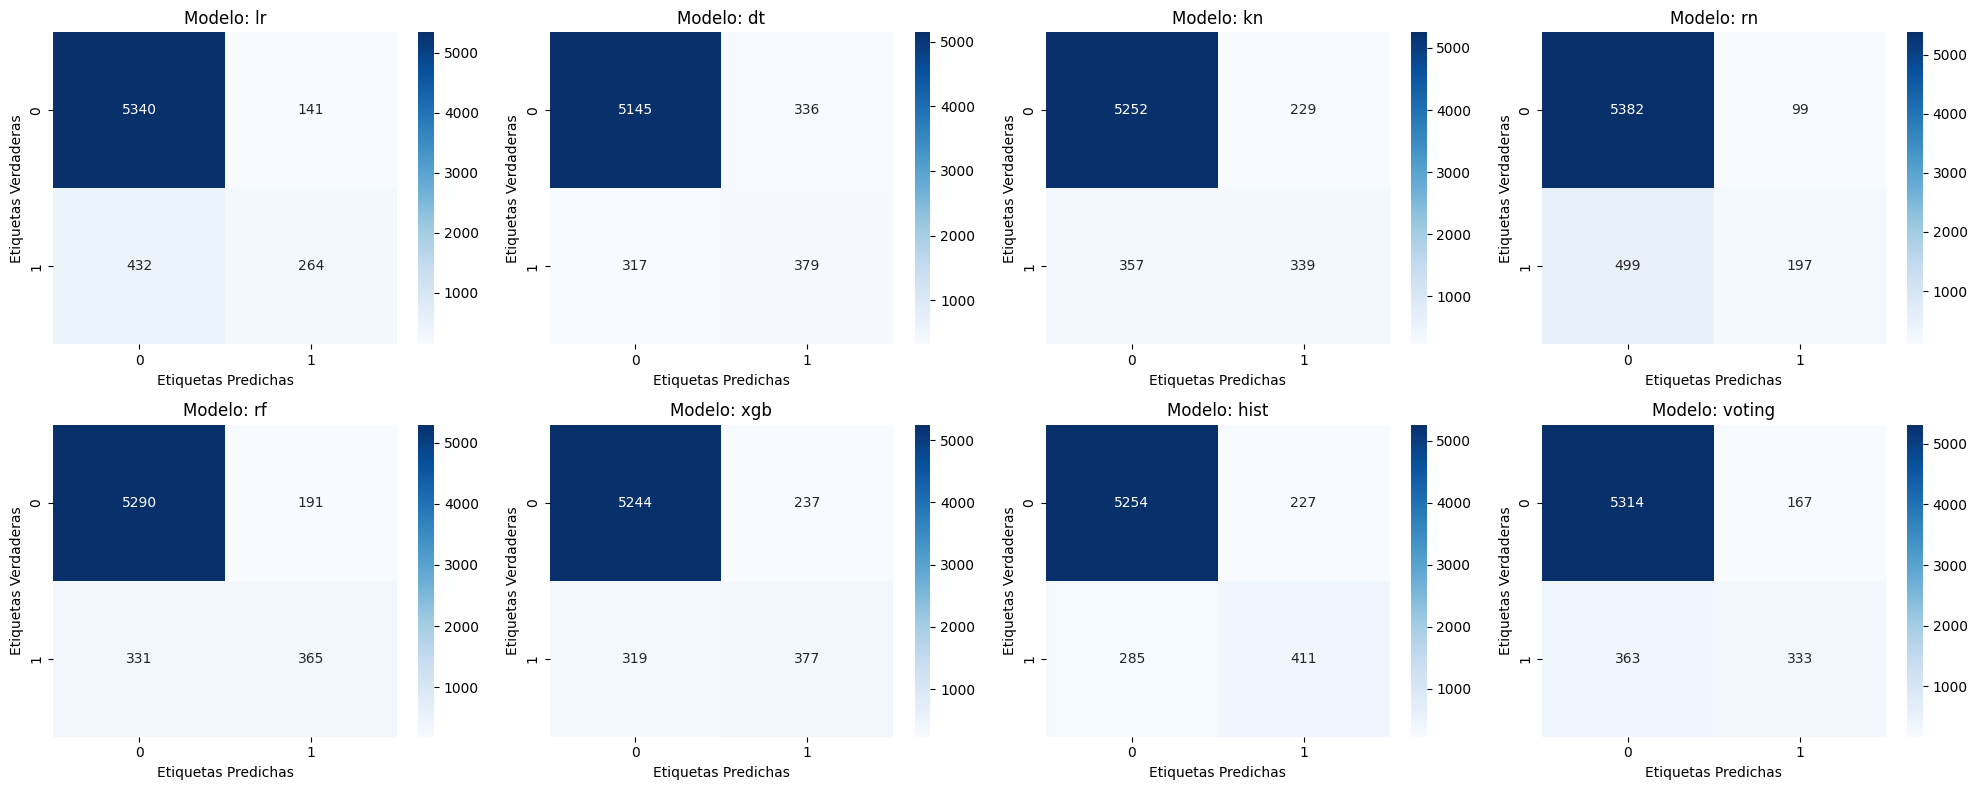

In [ ]:
print_confusion_matrix()

***